## Codon Table Class

This class instantiates codon tables with arbitrary, user defined decoding strategies.

In [12]:
# import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import Bio.Data.CodonTable
import networkx as nx
from codonUtils import utils
import pickle

## Standard Code and Biological Dictionaries

The exact ordering of amino acids and stop codons in order to represent the Standard Code in a pythonic way (e.g. defined by iterating over zipped elements) pulled from NCBI (https://www.ncbi.nlm.nih.gov/Taxonomy/Utils/wprintgc.cgi#SG1).

In [77]:
# define set of amino acids
DNA_dictionary = set(['u','c','a','g'])
DNA_list = ['u','c','a','g']

# define set of amino acids (* is stop)
AA_dictionary = set(['F','L','I','M','V','S','P',
                     'T','A','Y','H','Q','N','K',
                     'D','E','C','W','R','G','*'])
AA_list = ['F','L','I','M','V','S','P',
           'T','A','Y','H','Q','N','K',
           'D','E','C','W','R','G','*']

# define set of triplet codons
triplet_codons = [base1+base2+base3 
                  for base1 in DNA_list
                  for base2 in DNA_list
                  for base3 in DNA_list]

# define string of ordered codons in standard code
orderedAA = 'FFLLSSSSYY**CC*WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'

# define dict representing standard code
standardCode = dict(zip(triplet_codons, orderedAA))

## Visualization Object for Codon Tables

This class is designed to take dictionaries representing triplet codon tables and visualizing them in 3D space. For simplicity, the default visualization metric used is the 1982 hydrophobicity scale developed by Kyte and Doolittle (1).

In [78]:
class codonTable:
    ''' A class used to handle codon table objects.
    '''
    def __init__(self, codonTable=None, ordering=None, norm=True):
        '''Automatically loads object with a codonTable and a
        comparison function between amino acids "ordering". bool norm is used
        to tell tableToGraph whether or not to set node values based on
        absolute value of metric or just the ordering. This nomenclature is
        consistent throughout the object.

        Parameters
        ----------
        - dict codonTable=None: represents codon table
        - dict ordering=None: represents the mapping of residues to some metric
        - bool norm=True: true->use residue ordering; false->use metric
            absolute value
        Returns
        -------
        codonTable obj: returns a codonTable object
        '''
        # Define codonTable if not user defined
        if codonTable == None:
            # load standard codon table using Biopython
            codonTable = utils.standardTable
        # Define AA color ordering if not defined
        if ordering == None:
            # default to Kyte and Doolittle ordering
            ordering = utils.kdHydrophobicity

        # Assign assign instance attributes
        self.utils = utils
        self.codonTable = codonTable
        self.ordering = ordering
        self.codonGraph = self.tableToGraph(codonTable, norm)

    def sortOrdering(self):
        '''
        Returns the order of amino acids as defined by the mapping dictionary
        as a numpy array

        Parameters
        ----------
        None

        Returns
        -------
        np.array AA_array: an array of residues sorted by a metric
        '''
        # declare ordering array
        hydr_array = np.zeros(len(self.ordering))
        # declare list of AA
        AA_list = []
        # iterate through dictionary and store
        for i, (AA, hydr) in enumerate(self.ordering.items()):
            AA_list.append(AA)
            hydr_array[i] = hydr

        # convert AA_list to a np.array
        AA_array = np.array(AA_list)
        # sort along hydr_array and return indices
        indices = np.argsort(hydr_array)
        # return sorted AA_array
        return AA_array[indices]

    def getVal(self, AA, norm=True):
        ''' Returns the "value" of an amino acid, using the self.ordering
        dictionary. The norm flag is most relevant to this function, as it
        determines whether to return the absolute value of self.ordering[AA] or
        the amino acid's relative index when ordered.
        '''
            # extract value to store
        if norm == True:
            # use AA order instead of absolute metric value
            order = self.sortOrdering()
            return np.where(order == AA)[0]
        else:
            # use metric value instead of order
            metric = self.ordering
            return metric[AA]

    def getCube(self, norm=True):
        ''' Takes the codon table (in dictionary form) and reporting function
        and returns a cube of 64 locations (represented as a 4x4x4 cube with
        values). For levity and brevity, the returned cube is called Borg. The
        normalization flag (norm=True) tells the method to use the order of AA
        as opposed to the exact value of the ordering metric for visualization

        Parameters
        ----------
        bool norm=True: true->use residue ordering; false->use metric
            absolute value

        Returns
        -------
        np.array Borg: a 4x4x4 np.array representing the codon table in 3D
        '''
            # declare Borg cube
        Borg = np.zeros([4,4,4])
        # define coordinate mappings for codon nt
        codonToInt = {
            'A' : 0,
            'U' : 1,
            'C' : 2,
            'G' : 3,
        }
        # loop over codonTable items
        for codon, AA in self.codonTable.items():
            # extract x, y and z values
            x = codonToInt[codon[0]]
            y = codonToInt[codon[1]]
            z = codonToInt[codon[2]]
            # store value in Borg cube
            Borg[x][y][z] = self.getVal(AA, norm)
        # return the Borg cube
        return Borg

    def getScatterData(self, norm=True):
        ''' Conerts the codon table to a format that is easily parsed by
        scatter(). returns 64 element long arrays representing the x, y, z and
        hydrophobicity values.

        Parameters
        ----------
        bool norm=True: true->use residue ordering; false->use metric
            absolute value

        Returns
        -------
        - np.array xs: represents the x values of position for each codon
        - np.array ys: represents the y values of position for each codon
        - np.array zx: represents the z values of position for each codon
        - np.array vals: represents the metric value for each codon (color)
        '''
        # declare arrays to return
        xs = np.zeros(64)
        ys = np.zeros(64)
        zs = np.zeros(64)
        vals = np.zeros(64)
        # define coordinate mappings for codon nt
        codonToInt = {
            'A' : 0,
            'U' : 1,
            'C' : 2,
            'G' : 3,
        }
        # loop over codonTable items
        for i, (codon, AA) in enumerate(self.codonTable.items()):
            # skip stop codons for now
            if AA == '*':
                continue
            # extract x, y and z values
            xs[i] = codonToInt[codon[0]]
            ys[i] = codonToInt[codon[1]]
            zs[i] = codonToInt[codon[2]]
            # extract value to store
            vals[i] = self.getVal(AA, norm)
        # return arrays
        return xs, ys, zs, vals

    def tableToGraph(self, table=None, norm=True):
        ''' Takes a dictionary representing a codon table as an input and
        returns a networkx graph representing that table. If no table is given,
        the function will default to using self.codonTable.

        Parameters
        ----------
        - dict table=None: dict representing a codon table
        - bool norm=True: true->use residue ordering; false->use metric
            absolute value

        Returns
        -------
        nx.Graph codonGraph: a networkx graph representing the codon table
        '''
        # define Prob of single point mutations
        p_mut = 1/12
        # handle default table values
        if table == None:
            table = self.codonTable
        # declare graph
        codonGraph = nx.Graph()
        # call utils.getAAcounts to get degeneracy
        aaCounts = self.utils.getAAcounts(table)
        # call utils.getResiConnectivity to get dict representing graph
        graphDict = self.utils.getResiConnectivity(table)
        # initialize all nodes
        for resi in graphDict.keys():
            # add node for current residue
            count = aaCounts[resi]
            kd = self.getVal(resi, norm)
            codonGraph.add_node(resi, count=count, kd=kd)

        # parse edges from graphDict into networkx graph
        for A1, neighbors in graphDict.items():
            # declare dictionary to hold edge weights
            edgeDict = {}
            # populate edge dictionary
            for (A2, level) in neighbors:
                if A2 not in edgeDict:
                    edgeDict[A2] = p_mut**level
                else:
                    edgeDict[A2] += p_mut**level
            # convert edge dictionary into edges
            for A2, weight in edgeDict.items():
                codonGraph.add_edge(A1, A2, weight=weight)

        #return network
        return codonGraph

    def plot3d(self, title="", norm=True):
        ''' Represents self.table in 3D space. Returns the figure handle of the
        visualization. Optionally puts a title in the figure.

        Parameters
        ----------
        - str title="": an optional input to define the title of the plot
        - bool norm=True: true->use residue ordering; false->use metric
            absolute value

        Returns
        -------
        plt.figure fig: matplotlib figure handle for the resulting plot
        '''
        # call getScatterData to extract arrays from codon table
        xs, ys, zs, vals = self.getScatterData(norm)
        # initialize figure and axes objects
        fig = plt.figure()
        ax = Axes3D(fig)
        # plot data
        scat = ax.scatter(xs,ys,zs,s=1000,c=vals)
        cbar = plt.colorbar(scat)
        # set axes labels and ticks
        ticks = np.arange(0,4)
        tick_labels = ['A', 'U', 'C', 'G']

        ax.set_xlabel('Position 1')
        ax.set_ylabel('Position 2')
        ax.set_zlabel('Position 3')

        ax.set_xticks(ticks)
        ax.set_xticklabels(tick_labels)

        ax.set_yticks(ticks)
        ax.set_yticklabels(tick_labels)

        ax.set_zticks(ticks)
        ax.set_zticklabels(tick_labels)
        # format title
        if title != "":
            plt.title(title)
        #show figure
        plt.show()
        #return figure
        return fig

    def plotGraph(self, title="", norm=True, node_val='kd'):
        ''' Represents self.codonTable as a network capturing the adjacency of
        the amino acids. Two amino acids are defined as adjacent if a codon
        representing AA_1 can be mutated to represent AA_2 without representing
        an intermediate residue. The edge weight is defined by the probability
        of mutating to another AA:

            P(a1, a2) = \Sigma_i p^{n_i}

        node_val tells the plotter what should be represented using the node
        color value (defaults to kdHydropathy). Returns figure handle for
        plotted figure.

        Parameters
        ----------
        - str title="": an optional input to define the title of the plot
        - bool norm=True: true->use residue ordering; false->use metric
            absolute value
        - str node_val='kd': an optional input to specify the coloration of nodes

        Returns
        -------
        plt.figure fig: matplotlib figure handle for the resulting plot

        Known Bugs
        ----------
        Edge weight may be changing between iterations! confirm this and fix
        '''
        # unpack graph
        G = self.codonGraph
        # unpack and normalize edge weights and node values for visualization
        weights = np.array(
            [edge['weight'] for (a1, a2, edge) in G.edges(data=True)]
        )
        weights /= np.mean(weights)
        nodeVals = [data[node_val] for (node, data) in G.nodes(data=True)]
        # set up layout
        positions = nx.spring_layout(G, iterations=100)
        # draw graph
        fig = plt.figure()
        plt.axis('off')
        nodes = nx.draw_networkx_nodes(G, positions, node_color=nodeVals)
        edges = nx.draw_networkx_edges(G, positions, width=weights)
        labels = nx.draw_networkx_labels(G, positions)
        # draw color bar
        cbar = plt.colorbar(nodes)
        # format graph
        if title != "":
            plt.title(title)
        plt.show()
        return fig

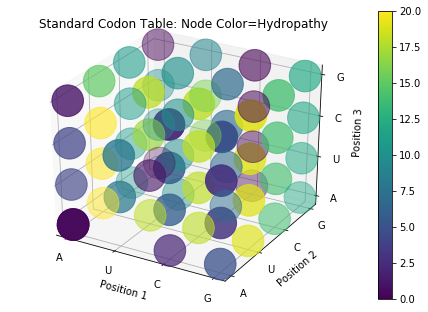

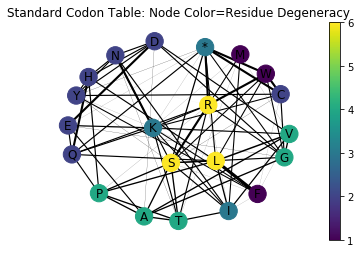

In [79]:
# Test script for codonTable
%matplotlib inline
test = codonTable()
fig = test.plot3d('Standard Codon Table: Node Color=Hydropathy', )
fig2 = test.plotGraph('Standard Codon Table: Node Color=Residue Degeneracy', node_val='count')

## Monte Carlo Simulation Class
This is the class for handling walking through Codon Table space to optimize for a user defined cost function. Defaults to self.cost() if not given. Any uses defined cost function should accept a Python dict representing the codon table (C --> AA) as an input and output a float to be maximized over (must set self.run() to minimization otherwise). Optionally should accept codonTable class as input. Uses the Polar Requirement Scale (3) as a measure of codon similarity.

In [80]:
#define Monte Carlo Simulation class
class MonteCarlo:
    '''MonteCarlo: A class designed to optimize a codon table given an
    arbitrary objective function to minimize/maximize
    '''
    def __init__(self, table=utils.standardTable,
                costfxn=None, wobble_rule = 'standard'):
        '''MonteCarlo.__init__: the init function for the MonteCarlo class.
        Optionally allows the user to specify the starting codon table,
        associated objective function, and which wobble_rules should be
        followed. Default values are supplied if the user does not specify
        them (i.e. Standard Code, 47 block wobble rule)

        Parameters
        ----------
        - dict table = utils.standardTable: a python dict representing the
            codon table. Also optionally accepts a codonTable object.
        - func costfxn = None: a function that takes a python dict as an
            input and outputs a cost associated with that table. If no
            funciton is supplied, defaults to maxMutMinVar.
        - str wobble_rule = 'standard': a string telling the simulator which
            wobble rules to follow for accepting new tablesi

            Acceptable inputs:
            - 'standard' : 47 blocks, 2 stop codons
            - 'preserveBlock' : maintain same block structure as standard
                table
            - 'unrestricted' : 63 open blocks, at least 0 of every AA and
                stop.
        Returns
        -------
        MonteCarlo obj: returns an instance of the MonteCarlo object
        '''
        # handle codonTable objects being passed
        if type(table) == codonTable:
            table = codonTable.codonTable
        # handle costfxn input
        if costfxn == None:
            costfxn = self.maxMutMinVar
        # calculate some attributes
        resiCounts = utils.getAAcounts(table)
        connectivity = utils.getCodonConnectivity(table)
        # assign attributes
        self.table = table
        self.costfxn = costfxn
        self.resiCounts = resiCounts
        self.connectivity = connectivity
        self.utils = utils
        self.wobble_rule = wobble_rule

    ######################################
    ##          Public  Methods         ##
    ######################################


    def run(self, objective = None, algorithm = None, minflag = False):
        '''MonteCarlo.run: the method used to handle searching through codon space using a defined search algorithm and objective function.

        Parameters
        ----------

        Returns
        -------
        '''
        # handle default selections
        if objective == None:
            objective = self.maxMutMinVar
        if algorithm == None:
            algorithm = self.GDA
        return False

    def GDA(self):
        #ToDo: fill out GDA
        return False


    def tableShuffle(self, table):
        '''Takes a codon table as an input and shuffles it to produce a new,
            similar table in order to traverse table space.

        Parameters
        ----------
        dict table: a python dict representing a codon table starting point

        Returns
        -------
        dict newTable: a python dict representing the next codon table
        '''
        
        return False



    @staticmethod
    def maxMutMinVar(table, counts, connectivity):
        '''MonteCarlo.maxMutMinVar: the default cost function for class.
        Implements a version of the cost function used by Novozhilov et al.
        2007, but optimizes for maximizing mutability while minimizing variance
        per mutation

        Parameters
        ----------
        - dict table: a python dictionary representing the codon table to
            evaluate
        - dict counts: a python dictionary representing the number of codons
            encoding for a particular amino acid in the given table
        - dict connectivity: a python dictionary mapping str codon --> list of
            (str codon, int dist) representing which codons can be reached from
            the input codon without tracing intermediate residues, along with
            the number of mutations to that codon

        Returns
        -------
        float metric: the absolute number score of the given table
        '''
        # initialize cost variable, declare polar requirement scale
        metric = 0
        PRS = utils.PRS
        # loop over source codons
        for c_1 in table.keys():
            # calculate AA degeneracy; skip stop codons
            AA_1 = table[c_1]
            if AA_1 == '*':         # skips stops
                continue
            f_c = 1/counts[AA_1]
            # loop over sink codons
            for (c_2, dist) in connectivity[c_1]:
                # get second AA, skip stop codons
                AA_2 = table[c_2]
                if AA_2 == '*':
                    continue
                # calculate components of objective function
                d_c12 = 1/(1 + (PRS[AA_1] - PRS[AA_2])**2)
                P_c12 = (1/12)**dist
                # calculate contribution to metric from this pair
                metric += f_c * P_c12 * d_c12
        # return resulting metric
        return metric

    ######################################
    ##          Private Methods         ##
    ######################################



In [81]:
# Debugging
sim = MonteCarlo()
table = sim.table
counts = sim.resiCounts
connect = sim.connectivity

%timeit sim.maxMutMinVar(table, counts, connect)

643 µs ± 8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
blockstruct = utils.naturalBlock
table = utils.standardTable
blocks = utils.tableToBlocks(table, blockstruct)



{0: ['UUU', 'UUC'],
 1: ['UUA', 'UUG'],
 2: ['CUU', 'CUC', 'CUA', 'CUG'],
 3: ['AUU', 'AUC', 'AUA'],
 4: ['AUG'],
 5: ['GUU', 'GUC', 'GUA', 'GUG'],
 6: ['UCU', 'UCC', 'UCA', 'UCG'],
 7: ['CCU', 'CCC', 'CCA', 'CCG'],
 8: ['ACU', 'ACC', 'ACA', 'ACG'],
 9: ['GCU', 'GCC', 'GCA', 'GCG'],
 10: ['UAU', 'UAC'],
 11: ['CAU', 'CAC'],
 12: ['CAA', 'CAG'],
 13: ['AAU', 'AAC'],
 14: ['AAA', 'AAG'],
 15: ['GAU', 'GAC'],
 16: ['GAA', 'GAG'],
 17: ['UGU', 'UGC'],
 18: ['UGG'],
 19: ['CGU', 'CGC', 'CGA', 'CGG'],
 20: ['AGU', 'AGC'],
 21: ['AGA', 'AGG'],
 22: ['GGU', 'GGC', 'GGA', 'GGG']}

In [9]:
table

{'AAA': 'K',
 'AAC': 'N',
 'AAG': 'K',
 'AAU': 'N',
 'ACA': 'T',
 'ACC': 'T',
 'ACG': 'T',
 'ACU': 'T',
 'AGA': 'R',
 'AGC': 'S',
 'AGG': 'R',
 'AGU': 'S',
 'AUA': 'I',
 'AUC': 'I',
 'AUG': 'M',
 'AUU': 'I',
 'CAA': 'Q',
 'CAC': 'H',
 'CAG': 'Q',
 'CAU': 'H',
 'CCA': 'P',
 'CCC': 'P',
 'CCG': 'P',
 'CCU': 'P',
 'CGA': 'R',
 'CGC': 'R',
 'CGG': 'R',
 'CGU': 'R',
 'CUA': 'L',
 'CUC': 'L',
 'CUG': 'L',
 'CUU': 'L',
 'GAA': 'E',
 'GAC': 'D',
 'GAG': 'E',
 'GAU': 'D',
 'GCA': 'A',
 'GCC': 'A',
 'GCG': 'A',
 'GCU': 'A',
 'GGA': 'G',
 'GGC': 'G',
 'GGG': 'G',
 'GGU': 'G',
 'GUA': 'V',
 'GUC': 'V',
 'GUG': 'V',
 'GUU': 'V',
 'UAA': '*',
 'UAC': 'Y',
 'UAG': '*',
 'UAU': 'Y',
 'UCA': 'S',
 'UCC': 'S',
 'UCG': 'S',
 'UCU': 'S',
 'UGA': '*',
 'UGC': 'C',
 'UGG': 'W',
 'UGU': 'C',
 'UUA': 'L',
 'UUC': 'F',
 'UUG': 'L',
 'UUU': 'F'}

In [85]:
# test the pickle
with open('utilsDefinitions.pickle', 'rb') as handle:
    pickle.load(handle)


## References
1. Kyte, J. & Doolittle, R. F. A simple method for displaying the hydropathic character of a protein. J. Mol. Biol. 157, 105–132 (1982).
1. Novozhilov, A. S., Wolf, Y. I. & Koonin, E. V. Evolution of the genetic code: partial optimization of a random code for robustness to translation error in a rugged fitness landscape. Biol. Direct 2, 24 (2007).
1. Woese, C. R., Dugre, D. H., Saxinger, W. C. & Dugre, S. A. The Molecular Basis for the Genetic Code. Proc. Natl. Acad. Sci. 55, 966–974 (1966).